In [1]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data/t2e/text_train.csv')
df = df.append(pd.read_csv('data/t2e/text_test.csv'))
display(df.head())

,wav_file,label,transcription
0,Ses01F_script01_3_M014,4,you felt something that far back ?
1,Ses01M_script01_1_F010,4,what ?
2,Ses02F_script03_2_F043,0,thank god i realized what you are i d never ma...
3,Ses05F_impro02_M039,4,three weeks ?
4,Ses02M_script02_2_F031,2,well but this isn t anything like i thought an...


In [2]:
col = ['label', 'transcription']
df = df[col]

In [3]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [4]:
df.columns = ['label', 'transcription']

In [5]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

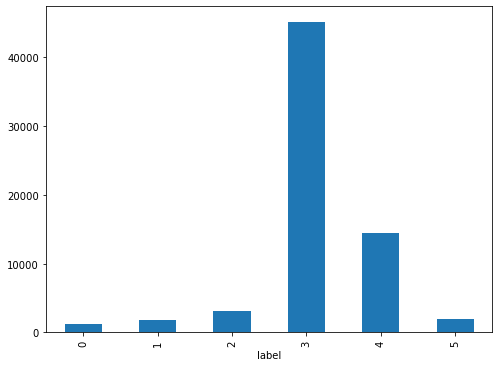

In [6]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(67528, 2606)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [9]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    print(classification_report(y_test, pred, target_names=emo_keys))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.905
Test Set F-score =  0.671
Test Set Precision =  0.752
Test Set Recall =  0.630
              precision    recall  f1-score   support

         ang       0.73      0.38      0.50       234
         hap       0.68      0.47      0.56       353
         sad       0.57      0.73      0.64       629
         fea       0.93      1.00      0.96      9059
         sur       0.98      0.81      0.89      2843
         neu       0.61      0.38      0.47       388

    accuracy                           0.90     13506
   macro avg       0.75      0.63      0.67     13506
weighted avg       0.90      0.90      0.90     13506

Confusion matrix, without normalization
[[  90    8   98   18    7   13]
 [   1  167  112   33    9   31]
 [  23   31  462   50   13   50]
 [   0    0    0 9059    0    0]
 [   0    0    0  550 2293    0]
 [   9   39  134   41   16  149]]


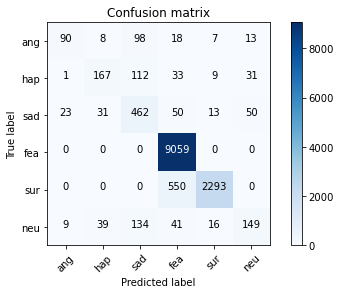

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/t2e/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

[17:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.841
Test Set F-score =  0.478
Test Set Precision =  0.758
Test Set Recall =  0.409
              precision    recall  f1-score   support

         ang       0.77      0.13      0.22       234
         hap       0.77      0.20      0.31       353
         sad       0.63      0.31      0.41       629
         fea       0.83      1.00      0.91      9059
         sur       0.92      0.69      0.79      2843
         neu       0.63      0.14      0.23       388

    accuracy                           0.84     13506
   macro avg       0.76      0.41      0.48     13506
weighted avg       0.83      0.84      0.81     13506

Confusion matrix, without normalization
[[  30    1   32  144   25    2]
 [   0   69   39  188   42   15]
 [   7   15  193  342   57   15]
 [   0    0 

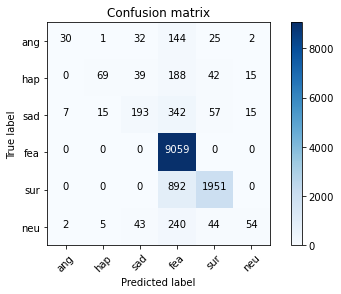

In [11]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/t2e/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Test Set Accuracy =  0.905
Test Set F-score =  0.686
Test Set Precision =  0.729
Test Set Recall =  0.652
Confusion matrix, without normalization
[[ 119    5   58   20    8   24]
 [  10  206   56   29   15   37]
 [  45   34  388   54   14   94]
 [   0    0    0 9059    0    0]
 [   0    0    0  550 2293    0]
 [  17   42  113   40   21  155]]


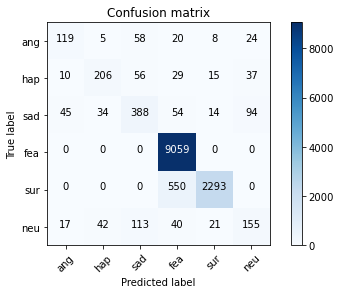

In [12]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
    
with open('trained_models/t2e/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.891
Test Set F-score =  0.626
Test Set Precision =  0.739
Test Set Recall =  0.574
              precision    recall  f1-score   support

         ang       0.71      0.32      0.44       234
         hap       0.80      0.43      0.56       353
         sad       0.54      0.64      0.59       629
         fea       0.92      1.00      0.96      9059
         sur       0.92      0.79      0.85      2843
         neu       0.53      0.27      0.36       388

    accuracy                           0.89     13506
   macro avg       0.74      0.57      0.63     13506
weighted avg       0.89      0.89      0.88     13506

Confusion matrix, without normalization
[[  75    8   87   26   20   18]
 [   1  151   86   35   61   19]
 [  22   13  401   67   71   55]
 [   0    0    0 9059    0    0]
 [   0    0    0  596 2247    0]
 [   7   16  162   55   44  104]]


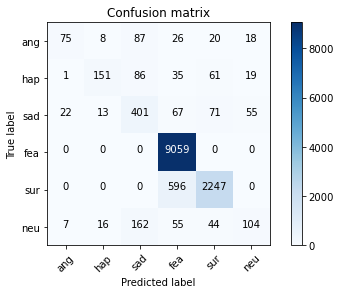

In [13]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/t2e/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Iteration 1, loss = 0.33803486
Iteration 2, loss = 0.25720264
Iteration 3, loss = 0.24205111
Iteration 4, loss = 0.23217587
Iteration 5, loss = 0.22606913
Iteration 6, loss = 0.22137274
Iteration 7, loss = 0.21777948
Iteration 8, loss = 0.21530658
Iteration 9, loss = 0.21394431
Iteration 10, loss = 0.21283861
Iteration 11, loss = 0.21179211
Iteration 12, loss = 0.21103771
Iteration 13, loss = 0.20963983
Iteration 14, loss = 0.20896703
Iteration 15, loss = 0.20796466
Iteration 16, loss = 0.20746481
Iteration 17, loss = 0.20724985
Iteration 18, loss = 0.20655188


C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Test Set Accuracy =  0.906
Test Set F-score =  0.687
Test Set Precision =  0.725
Test Set Recall =  0.659
              precision    recall  f1-score   support

         ang       0.55      0.54      0.55       234
         hap       0.74      0.55      0.63       353
         sad       0.62      0.64      0.63       629
         fea       0.93      1.00      0.97      9059
         sur       0.98      0.81      0.88      2843
         neu       0.54      0.41      0.47       388

    accuracy                           0.91     13506
   macro avg       0.73      0.66      0.69     13506
weighted avg       0.90      0.91      0.90     13506

Confusion matrix, without normalization
[[ 127    3   61   17    7   19]
 [  17  193   68   22   12   41]
 [  62   33  405   37   14   78]
 [   0    0    0 9059    0    0]
 [   0    0    0  550 2293    0]
 [  25   33  121   30   19  160]]


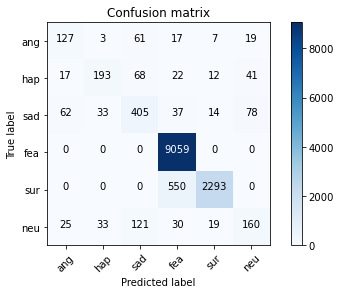

In [16]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=True, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/t2e/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

In [22]:
with open('trained_models/t2e/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.896
Test Set F-score =  0.646
Test Set Precision =  0.747
Test Set Recall =  0.591
              precision    recall  f1-score   support

         ang       0.72      0.35      0.47       234
         hap       0.79      0.48      0.59       353
         sad       0.60      0.62      0.61       629
         fea       0.92      1.00      0.96      9059
         sur       0.96      0.81      0.87      2843
         neu       0.51      0.30      0.37       388

    accuracy                           0.90     13506
   macro avg       0.75      0.59      0.65     13506
weighted avg       0.89      0.90      0.89     13506

Confusion matrix, without normalization
[[  81    2   76   43   14   18]
 [   2  168   58   62   33   30]
 [  23   18  391  102   32   63]
 [   0    0    0 9059    0    0]
 [   0    0    0  550 2293    0]
 [   7   25  129   83   29  115]]


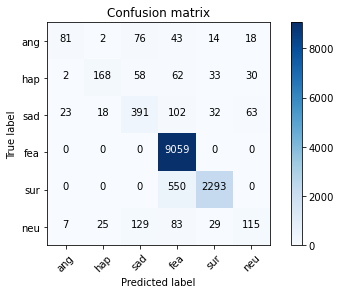

In [23]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/t2e/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

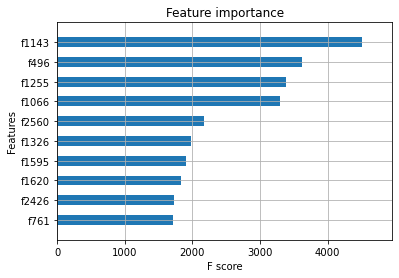

In [24]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [25]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.        , 0.        , 0.00153511, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Test Set Accuracy =  0.671
Test Set F-score =  0.134
Test Set Precision =  0.112
Test Set Recall =  0.167
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       234
         hap       0.00      0.00      0.00       353
         sad       0.00      0.00      0.00       629
         fea       0.67      1.00      0.80      9059
         sur       0.00      0.00      0.00      2843
         neu       0.00      0.00      0.00       388

    accuracy                           0.67     13506
   macro avg       0.11      0.17      0.13     13506
weighted avg       0.45      0.67      0.54     13506



C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\m

Confusion matrix, without normalization
[[   0    0    0  234    0    0]
 [   0    0    0  353    0    0]
 [   0    0    0  629    0    0]
 [   0    0    0 9059    0    0]
 [   0    0    0 2843    0    0]
 [   0    0    0  388    0    0]]


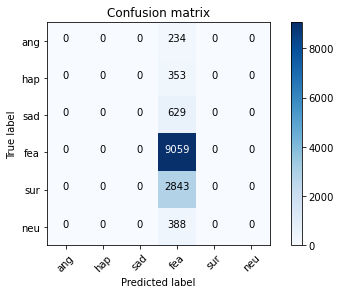

In [26]:
with open('pred_probas/text_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)
    
display_results(y_test, lstm_pred_probs)

Test Set Accuracy =  0.906
Test Set F-score =  0.690
Test Set Precision =  0.760
Test Set Recall =  0.646
              precision    recall  f1-score   support

         ang       0.69      0.47      0.56       234
         hap       0.79      0.53      0.63       353
         sad       0.61      0.69      0.65       629
         fea       0.93      1.00      0.96      9059
         sur       0.97      0.81      0.88      2843
         neu       0.56      0.38      0.46       388

    accuracy                           0.91     13506
   macro avg       0.76      0.65      0.69     13506
weighted avg       0.90      0.91      0.90     13506

Confusion matrix, without normalization
[[ 109    1   73   23   10   18]
 [   5  186   75   35   20   32]
 [  31   22  436   57   18   65]
 [   0    0    0 9059    0    0]
 [   0    0    0  550 2293    0]
 [  12   25  128   52   22  149]]


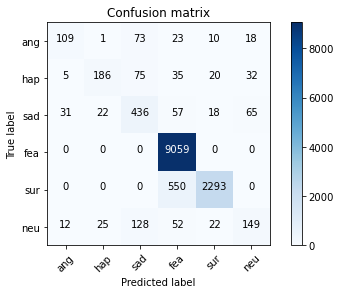

In [27]:
# Load predicted probabilities
with open('pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)

In [28]:
top_n = [500, 1000, 1500, 2000]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=600, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 500 features:
[19:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.841
Test Set F-score =  0.478
Test Set Precision =  0.758
Test Set Recall =  0.409
              precision    recall  f1-score   support

         ang       0.77      0.13      0.22       234
         hap       0.77      0.20      0.31       353
         sad       0.63      0.31      0.41       629
         fea       0.83      1.00      0.91      9059
         sur       0.92      0.69      0.79      2843
         neu       0.63      0.14      0.23       388

    accuracy                           0.84     13506
   macro avg       0.76      0.41      0.48     13506
weighted avg       0.83      0.84      0.81     13506

Stats for top 1000 features:
[22:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593f